In [1]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt

In [25]:
#read in the data, get normalized adjacency (NxN)
%run helpers_preproc.ipynb
mesh_dir = 'SHREC11/'

label_np = np.array(readLbl(mesh_dir+'labels.txt'))
label_mat_np = np.where(igl.all_pairs_distances(label_np,label_np,False) > 0.5,0,1)
label_mat = torch.tensor(label_mat_np,requires_grad=False)

In [35]:
normed_adjMats_list = []
node_sigs_list = []

for i in range(600):
    fName = 'T' + str(i) + '.obj'
    adj_noscale_read = obj_2_adj_noscale(mesh_dir + fName)
    adj_scaled_read = obj_2_adj(mesh_dir + fName)

    if (adj_scaled_read.shape[0] < 252):
        adj_noscale = np.empty([252,252])
        adj_scaled = np.empty([252,252])
    else:
        adj_noscale = adj_noscale_read
        adj_scaled = adj_scaled_read

    adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])

    #node level signal extraction
    node_degs = np.sum(adj_noscale,axis = 0)
    node_neigh_max = np.max(adj_scaled,axis = 0)
    node_neigh_min = np.min(adj_scaled,axis = 0)
    node_neigh_sum = np.sum(adj_scaled,axis = 0)
    node_neigh_mean = np.sum(adj_scaled,axis = 0)

    node_sig = np.stack([node_degs,node_neigh_max,node_neigh_min,node_neigh_sum,node_neigh_mean],axis = 1)
    node_sigs_list.append(node_sig)

    normed_adjMats_list.append(adj_normalized)

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_28489/3962357194.py:16: RuntimeWarning: invalid value encountered in true_divide
  adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])
/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_28489/3962357194.py:23: RuntimeWarning: divide by zero encountered in true_divide
  node_neigh_mean = np.sum(adj_scaled,axis = 0) /node_degs
/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_28489/3962357194.py:23: RuntimeWarning: overflow encountered in true_divide
  node_neigh_mean = np.sum(adj_scaled,axis = 0) /node_degs


In [36]:
normed_adjMats = np.stack(normed_adjMats_list)
node_sigs = np.stack(node_sigs_list)

normed_adjMats = torch.tensor(normed_adjMats,requires_grad=False).float()
node_sigs = torch.tensor(node_sigs,requires_grad=False).float()

normed_adjMats = torch.nan_to_num(normed_adjMats,0,0,0)
node_sigs = torch.nan_to_num(node_sigs,0,0,0)

In [37]:
node_sigs

tensor([[[5.0000, 0.0888, 0.0000, 0.3595, 0.0719, 0.2554],
         [7.0000, 0.1017, 0.0000, 0.4655, 0.0665, 0.1552],
         [6.0000, 0.0920, 0.0000, 0.4395, 0.0733, 0.2202],
         ...,
         [7.0000, 0.1142, 0.0000, 0.5429, 0.0776, 0.2111],
         [6.0000, 0.1352, 0.0000, 0.4959, 0.0826, 0.2809],
         [7.0000, 0.1352, 0.0000, 0.5233, 0.0748, 0.1963]],

        [[5.0000, 0.1061, 0.0000, 0.4014, 0.0803, 0.3188],
         [5.0000, 0.1546, 0.0000, 0.4404, 0.0881, 0.3847],
         [5.0000, 0.2171, 0.0000, 0.5315, 0.1063, 0.5617],
         ...,
         [5.0000, 0.1340, 0.0000, 0.4817, 0.0963, 0.4593],
         [6.0000, 0.1705, 0.0000, 0.7666, 0.1278, 0.6700],
         [5.0000, 0.1284, 0.0000, 0.4872, 0.0974, 0.4698]],

        [[4.0000, 0.1228, 0.0000, 0.3313, 0.0828, 0.4263],
         [5.0000, 0.2132, 0.0000, 0.5203, 0.1041, 0.5386],
         [4.0000, 0.1201, 0.0000, 0.2880, 0.0720, 0.3222],
         ...,
         [5.0000, 0.1041, 0.0000, 0.4604, 0.0921, 0.4189],
         [

In [39]:
class GCN(torch.nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.f = 5
        self.widths = widths
        self.weights = []
        self.weights.append(torch.autograd.Variable(torch.rand(size = [self.f,widths[0]])-0.5,requires_grad = True))

        for i in range(1,len(self.widths)):
            c = self.widths[i]
            self.weights.append(torch.autograd.Variable(torch.rand((self.widths[i-1],self.widths[i]))-0.5,requires_grad = True))

    def forward(self, adjM,node_sigM):
        curr_output = torch.tanh(torch.matmul(torch.matmul(adjM,node_sigM),self.weights[0])) #nxc
        for i in range(1,len(self.widths)):
            curr_output = torch.tanh(torch.matmul(torch.matmul(adjM,curr_output),self.weights[i])) #nxc

        return curr_output

tensor([[[ 0.1916,  0.0122, -0.2857,  ..., -0.4973, -0.0533, -0.0872],
         [ 0.1916,  0.0121, -0.2856,  ..., -0.4972, -0.0534, -0.0872],
         [ 0.1925,  0.0103, -0.2850,  ..., -0.4971, -0.0533, -0.0866],
         ...,
         [ 0.1934,  0.0076, -0.2839,  ..., -0.4964, -0.0534, -0.0861],
         [ 0.1934,  0.0079, -0.2835,  ..., -0.4963, -0.0537, -0.0863],
         [ 0.1939,  0.0071, -0.2829,  ..., -0.4962, -0.0537, -0.0861]],

        [[ 0.1801,  0.0275, -0.3029,  ..., -0.5005, -0.0485, -0.0892],
         [ 0.1756,  0.0364, -0.3088,  ..., -0.5030, -0.0471, -0.0905],
         [ 0.1788,  0.0305, -0.3046,  ..., -0.5016, -0.0481, -0.0895],
         ...,
         [ 0.1799,  0.0285, -0.3035,  ..., -0.5013, -0.0482, -0.0892],
         [ 0.1806,  0.0229, -0.3043,  ..., -0.5002, -0.0462, -0.0874],
         [ 0.1791,  0.0302, -0.3044,  ..., -0.5017, -0.0481, -0.0895]],

        [[ 0.1802,  0.0284, -0.3023,  ..., -0.5009, -0.0489, -0.0894],
         [ 0.1805,  0.0277, -0.3018,  ..., -0

In [73]:
class NNN(torch.nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.input_shape = 2520
        self.widths = widths
        self.weights = []
        self.weights.append(torch.autograd.Variable(torch.rand(size = [self.input_shape,widths[0]])-0.5,requires_grad = True))

        for i in range(1,len(self.widths)):
            c = self.widths[i]
            self.weights.append(torch.autograd.Variable(torch.rand((self.widths[i-1],self.widths[i]))-0.5,requires_grad = True))

    def forward(self, x):
        x = torch.flatten(x,1,2)
        torch.matmul(x,self.weights[0])
        curr_output = torch.tanh(torch.matmul(x,self.weights[0])) #nxc
        for i in range(1,len(self.widths)):
            curr_output = torch.tanh(torch.matmul(curr_output,self.weights[i])) #nxc

        return curr_output

In [75]:
g = GCN([10,10,10,10])
n = NNN([10,10,10,10])
output1 = g.forward(normed_adjMats,node_sigs)
output2 = n.forward(output1)
print(output1)
print(output2)

tensor(-2.0786, grad_fn=<AddBackward0>)
tensor(-2.0758, grad_fn=<AddBackward0>)
tensor(-2.0776, grad_fn=<AddBackward0>)
tensor(-2.0782, grad_fn=<AddBackward0>)
tensor(-2.0781, grad_fn=<AddBackward0>)
tensor(-2.0784, grad_fn=<AddBackward0>)
tensor(-2.0783, grad_fn=<AddBackward0>)
tensor(-2.0784, grad_fn=<AddBackward0>)
tensor(-2.0788, grad_fn=<AddBackward0>)
tensor(-2.0791, grad_fn=<AddBackward0>)
tensor(-2.0787, grad_fn=<AddBackward0>)
tensor(-2.0786, grad_fn=<AddBackward0>)
tensor(-2.0790, grad_fn=<AddBackward0>)
tensor(-2.0794, grad_fn=<AddBackward0>)
tensor(-2.0790, grad_fn=<AddBackward0>)
tensor(-2.0788, grad_fn=<AddBackward0>)
tensor(-2.0791, grad_fn=<AddBackward0>)
tensor(-2.0793, grad_fn=<AddBackward0>)
tensor(-2.0793, grad_fn=<AddBackward0>)
tensor(-2.0791, grad_fn=<AddBackward0>)
tensor(-2.0792, grad_fn=<AddBackward0>)
tensor(-2.0793, grad_fn=<AddBackward0>)
tensor(-2.0793, grad_fn=<AddBackward0>)
tensor(-2.0794, grad_fn=<AddBackward0>)
tensor(-2.0793, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [ ]:
def lossF(features):
    disMat = torch.cdist(features,features)
    sameType = disMat * (label_mat-torch.diag(torch.ones(600)))
    diffType = disMat * (1-label_mat)
    sameTypeMean = torch.sum(sameType) / 12000
    diffTypeMean = torch.sum(diffType) /348000

    sameTypeStd = torch.sum((sameType - sameTypeMean)**2) / 12000
    diffTypeStd = torch.sum((diffType - diffTypeMean)**2) / 348000

    #print(disMat)
    return  sameTypeMean - diffTypeMean + 0.2 * (sameTypeStd + diffTypeStd)

(array([0.09736706, 0.06140384, 0.04193166, 0.02912408, 0.02456172,
        0.01841873, 0.02455831, 0.01841873, 0.02140081, 0.01876956,
        0.02140081, 0.01578748, 0.01578748, 0.01227915, 0.01543665,
        0.01262999, 0.01438415, 0.01262999, 0.01052499, 0.01140207,
        0.01351103, 0.0117569 , 0.00965118, 0.01000214, 0.01087952,
        0.01017761, 0.00842285, 0.00772095, 0.01228333, 0.00912476,
        0.00789642, 0.00824738, 0.00561523, 0.00842285, 0.00491333,
        0.00754547, 0.00631714, 0.00666809, 0.00824738, 0.00684357,
        0.00772095, 0.00543976, 0.00403595, 0.00350952, 0.003685  ,
        0.00561523, 0.00333405, 0.00228119, 0.00350952, 0.00315857,
        0.00386047, 0.00298309, 0.003685  , 0.0043869 , 0.003685  ,
        0.00403595, 0.00333405, 0.00386047, 0.003685  , 0.00280762,
        0.0043869 , 0.00298309, 0.00350952, 0.00315857, 0.00228119,
        0.00263214, 0.00280762, 0.00228119, 0.00280762, 0.003685  ,
        0.00350952, 0.00105286, 0.00315857, 0.00

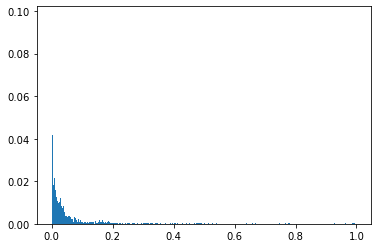

In [59]:
optimizer = optim.Adam(g.weights + n.weights,lr = 0.0001)
for i in range(10000):
    optimizer.zero_grad()
    output = n.forward(g.forward(normed_adjMats,node_sigs))
    loss = lossF(output)
    loss.backward()
    optimizer.step()
    print(loss)

(array([0.01881609, 0.01474138, 0.01222989, ..., 0.        , 0.        ,
        0.        ]),
 array([0.000e+00, 1.000e-03, 2.000e-03, ..., 7.997e+00, 7.998e+00,
        7.999e+00]),
 <BarContainer object of 7999 artists>)

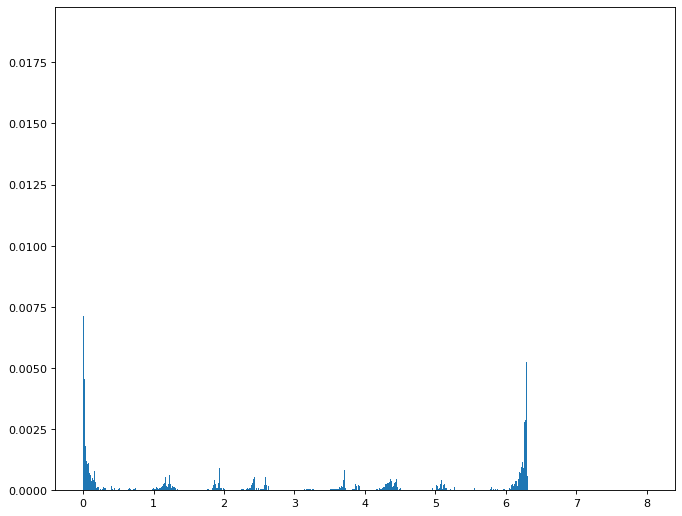

In [60]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat - torch.diag(torch.ones(600)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)
bins = torch.arange(0,0.1,0.001)

In [61]:
plt.hist(sameComp,bins=np.arange(0,1,0.001),weights=weightsSame,log = False)

In [62]:
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)
plt.hist(diffComp,bins=np.arange(0,8,0.001),weights=weightsDiff,log = False)

228192

In [63]:
BigDiffIndices = np.where(disMat.detach().numpy().flatten() > 0.1)[0].tolist()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

In [67]:
len(BigDiffIndices)

In [68]:
vizMat = np.zeros([30,30])
vizMat

array([[0.    , 1.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.05  ,
        0.    , 0.05  , 1.    , 0.745 , 0.    , 0.    , 0.    , 1.    ,
        1.    , 0.965 , 1.    , 0.    , 1.    , 1.    , 1.    , 1.    ,
        0.15  , 0.    , 0.84  , 1.    , 0.    , 1.    ],
       [1.    , 0.    , 1.    , 1.    , 0.    , 1.    , 1.    , 1.    ,
        1.    , 0.95  , 1.    , 1.    , 1.    , 1.    , 1.    , 0.05  ,
        0.    , 1.    , 0.    , 1.    , 0.    , 1.    , 0.95  , 0.    ,
        0.95  , 1.    , 1.    , 0.    , 1.    , 0.    ],
       [0.    , 1.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.05  ,
        0.    , 0.05  , 1.    , 0.7475, 0.    , 0.    , 0.    , 1.    ,
        1.    , 0.9725, 1.    , 0.    , 1.    , 1.    , 1.    , 1.    ,
        0.15  , 0.    , 0.85  , 1.    , 0.    , 1.    ],
       [0.    , 1.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.05  ,
        0.    , 0.05  , 1.    , 0.7475, 0.    , 0.    , 0.    , 1.    ,
        1.    , 0.96  , 1.    , 0.   

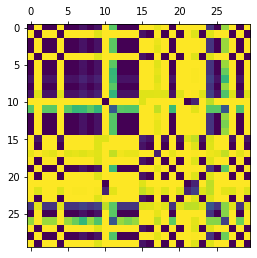

In [69]:
for index in BigDiffIndices:
    row, col = divmod(index,600)
    cat1, cat2 = int(label_np[row]),int(label_np[col])
    #print(cat1,cat2, (cat1 == cat2))
    vizMat[cat1,cat2] += 1
    vizMat[cat2,cat1] += 1


In [219]:
vizMat = vizMat / np.max(vizMat)
vizMat

array([[0.    , 1.    , 0.0475, 1.    , 1.    , 1.    , 1.    , 1.    ,
        1.    , 1.    , 1.    , 1.    , 0.15  , 0.85  , 0.045 , 1.    ,
        1.    , 1.    , 1.    , 0.    , 1.    , 1.    , 1.    , 1.    ,
        0.2   , 1.    , 1.    , 1.    , 0.2   , 1.    ],
       [1.    , 0.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
        1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
        1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
        1.    , 1.    , 1.    , 1.    , 1.    , 1.    ],
       [0.0475, 1.    , 0.04  , 1.    , 1.    , 1.    , 1.    , 1.    ,
        1.    , 1.    , 1.    , 1.    , 0.14  , 0.8575, 0.0175, 1.    ,
        1.    , 1.    , 1.    , 0.0325, 1.    , 1.    , 1.    , 1.    ,
        0.1975, 1.    , 1.    , 1.    , 0.2075, 1.    ],
       [1.    , 1.    , 1.    , 0.255 , 1.    , 1.    , 0.185 , 0.98  ,
        1.    , 0.94  , 1.    , 1.    , 1.    , 1.    , 1.    , 0.85  ,
        1.    , 1.    , 1.    , 1.   

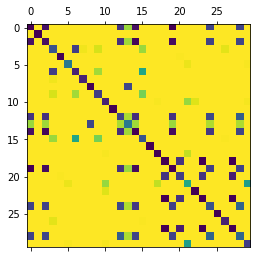

In [220]:
plt.matshow(vizMat)